# Tutorial for binning data from the HEXTOF instrument at FLASH

## Preparation

### Import necessary libraries

In [1]:
from typing import List
from pathlib import Path
import os

from sed import SedProcessor
from sed.dataset import dataset
import xarray as xr

%matplotlib widget
import matplotlib.pyplot as plt

### Get data paths

The paths are such that if you are on Maxwell, it uses those. Otherwise data is downloaded in current directory from Zenodo.

Generally, if it is your beamtime, you can both read the raw data and write to processed directory. However, for the public data, you can not write to processed directory.

In [2]:
beamtime_dir = "/asap3/flash/gpfs/pg2/2023/data/11019101" # on Maxwell
if os.path.exists(beamtime_dir) and os.access(beamtime_dir, os.R_OK):
    path = beamtime_dir + "/raw/hdf/offline/fl1user3"
    buffer_path = "Gd_W110/processed/"
else:
    # data_path can be defined and used to store the data in a specific location
    dataset.get("Gd_W110") # Put in Path to a storage of at least 10 GByte free space.
    path = dataset.dir
    buffer_path = path + "/processed/"

INFO - Not downloading Gd_W110 data as it already exists at "/home/runner/work/sed/sed/docs/tutorial/datasets/Gd_W110".
Set 'use_existing' to False if you want to download to a new location.


INFO - Using existing data path for "Gd_W110": "/home/runner/work/sed/sed/docs/tutorial/datasets/Gd_W110"


INFO - Gd_W110 data is already present.


### Config setup
Here we get the path to the config file and setup the relevant directories. This can also be done directly in the config file.

In [3]:
# pick the default configuration file for hextof@FLASH
config_file = Path('../sed/config/flash_example_config.yaml')
assert config_file.exists()

In [4]:
# here we setup a dictionary that will be used to override the path configuration
config_override = {
    "core": {
        "paths": {
            "data_raw_dir": path,
            "data_parquet_dir": buffer_path,
        },
    },
}

### cleanup previous config files
In this notebook, we will show how calibration parameters can be generated. Therefore we want to clean the local directory of previously generated files.

**WARNING** running the cell below will delete the "sed_config.yaml" file in the local directory. If these contain precious calibration parameters, **DO NOT RUN THIS CELL**.

In [5]:
local_folder_config = Path('./sed_config.yaml')
if local_folder_config.exists():
    os.remove(local_folder_config)
    print(f'deleted local config file {local_folder_config}')
assert not local_folder_config.exists()

deleted local config file sed_config.yaml


## Load a chessy sample run
The common starting point at a FLASH beamtime. Look at the Chessy sample!

- run 44762: Chessy - FoV = 450 µm

### Generate the Processor instance
this cell generates an instance of the `SedProcessor` class. It will be our workhorse for the entire workflow.

In [6]:
sp = SedProcessor(runs=[44762], config=config_override, system_config=config_file, collect_metadata=False, force_recreate=True)
# You can set collect_metadata=True if the scicat_url and scicat_token are defined

System config loaded from: [/home/runner/work/sed/sed/docs/sed/config/flash_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]
Reading files: 1 new files of 1 total.


All files converted successfully!
Filling nan values...
loading complete in  15.14 s


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   15.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   15.1s


### Add Jitter
In order to avoid artifacts arising from incommensurate binning sizes with those imposed during data collection, e.g. by the detector, we jitter all the digital columns.

In [7]:
sp.add_jitter()

### inspect the dataframe
Looking at the dataframe can give quick insight about the columns loaded and the data available. 
- `sp.dataframe` shows the structure of the dataframe without computing anything. Interesting here are the columns, and their type.
- The `sp.dataframe.head()` function accesses the first 5 events in the dataframe, giving us a view of what the values of each column look like, without computing the whole thing.  `sp.dataframe.tail()`does the same from the end. 
- `sp.dataframe.compute()` will compute the whole dataframe, and can take a while. We should avoid doing this.

In [8]:
sp.dataframe

Dask DataFrame Structure:
              trainId pulseId electronId timeStamp  dldPosX  dldPosY dldTimeSteps cryoTemperature dldTimeBinSize extractorCurrent extractorVoltage sampleBias sampleTemperature tofVoltage pulserSignAdc monochromatorPhotonEnergy   gmdBda      bam delayStage dldSectorID
npartitions=1                                                                                                                                                                                                                                                              
               uint32   int64      int64   float64  float64  float64      float64         float32        float32          float32          float32    float32           float32    float32       float32                   float32  float32  float32    float32        int8
                  ...     ...        ...       ...      ...      ...          ...             ...            ...              ...              ...        ...               ...        ...           ...                       ...      ...      ...        ...         ...
Dask Name: apply_jitter, 7 graph layers

In [9]:
sp.dataframe.head()

trainId  pulseId  electronId     timeStamp     dldPosX     dldPosY  \
0  1646339970       12           0  1.679395e+09  781.488162  690.488162   
1  1646339970       12           1  1.679395e+09  781.437440  691.437440   
2  1646339970       22           0  1.679395e+09  562.399776  231.399776   
3  1646339970       22           1  1.679395e+09  938.224158  947.224158   
4  1646339970       27           0  1.679395e+09  536.090966  854.090966   

   dldTimeSteps  cryoTemperature  dldTimeBinSize  extractorCurrent  \
0   3050.488162       303.940002        0.020576         -0.070368   
1   3049.437440       303.940002        0.020576         -0.070368   
2   5729.399776       303.940002        0.020576         -0.070368   
3   5730.224158       303.940002        0.020576         -0.070368   
4   1571.090966       303.940002        0.020576         -0.070368   

   extractorVoltage  sampleBias  sampleTemperature  tofVoltage  pulserSignAdc  \
0       6029.370117   -0.003489         304.940002   29.999065            NaN   
1       6029.370117   -0.003489         304.940002   29.999065            NaN   
2       6029.370117   -0.003489         304.940002   29.999065            NaN   
3       6029.370117   -0.003489         304.940002   29.999065            NaN   
4       6029.370117   -0.003489         304.940002   29.999065            NaN   

   monochromatorPhotonEnergy  gmdBda         bam  delayStage  dldSectorID  
0                        NaN     NaN  8976.09375         NaN            7  
1                        NaN     NaN  8976.09375         NaN            2  
2                        NaN     NaN  8990.37500         NaN            3  
3                        NaN     NaN  8990.37500         NaN            2  
4                        NaN     NaN  8982.87500         NaN            0

### Visualizing event histograms
For getting a first impression of the data, and to determine binning ranges, the method sp.`view_even_histogram()` allows visualizing the events in one dataframe partition as histograms. Default axes and ranges are defined in the config, and show the dldPosX, dldPosY, and dldTimeStep columns:

In [10]:
sp.view_event_histogram(dfpid=0)

### Binning
Here we define the parameters for binning the dataframe to an n-dimensional histogram, which we can then plot, analyze or save.

If you never saw this before, the type after `:` is a "hint" to what type the object to the left will have. We include them here to make sure you know what each variable should be.
```python
a:int = 1 # a is an integer
b:float = 1.0 # b is a float
c:str = 1 # we hint c to be a string, but it is still an integer
```
This is totally optional, but can help you keep track of what you are doing.

In [11]:
# the name of the axes on which we want to bin
axes: List[str] = ['dldPosY', 'dldPosX']
# the number of bins for each axis
bins: List[int] = [480, 480]
# for each axis, the range of values to consider
ranges: List[List[int]] = [[420,900], [420,900]]
# here we compute the histogram
res_chessy: xr.DataArray = sp.compute(bins=bins, axes=axes, ranges=ranges)

  0%|          | 0/1 [00:00<?, ?it/s]

### visualize the result
here we plot the binned histogram. The result is an xarray, which gives us some convenient visualization and simple plotting tools.

In [12]:
res_chessy

<xarray.DataArray (dldPosY: 480, dldPosX: 480)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * dldPosY  (dldPosY) float64 420.0 421.0 422.0 423.0 ... 897.0 898.0 899.0
  * dldPosX  (dldPosX) float64 420.0 421.0 422.0 423.0 ... 897.0 898.0 899.0
Attributes:
    units:      counts
    long_name:  photoelectron counts
    metadata:   {'jittering': ['dldPosX', 'dldPosY', 'dldTimeSteps']}

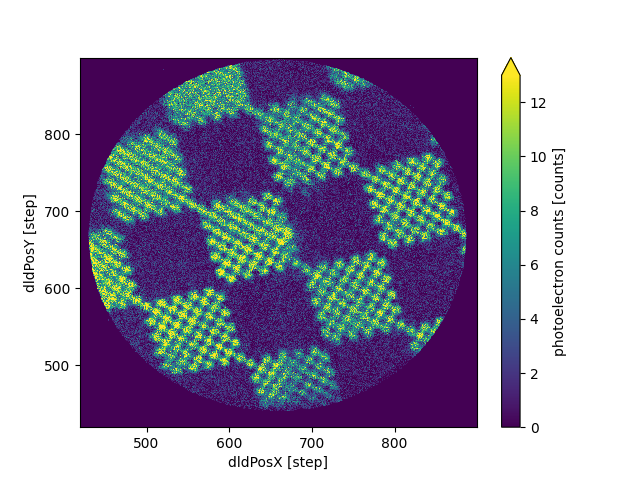

In [13]:
plt.figure()
res_chessy.plot(robust=True) # robust is used to avoid outliers to dominate the color scale

## Optical Spot Profile
Here we load runs 44798 and 44799, which show the profile of the optical spot on the same spatial view as in our chessy run above. The two differ in transmission, being $T=1.0$ and $T=0.5$ respectively.

In [14]:
sp = SedProcessor(runs=[44798], config=config_override, system_config=config_file, collect_metadata=False)
sp.add_jitter()
res_t05: xr.DataArray = sp.compute(bins=bins, axes=axes, ranges=ranges)

sp = SedProcessor(runs=[44799], config=config_override, system_config=config_file, collect_metadata=False)
sp.add_jitter()
res_t10: xr.DataArray = sp.compute(bins=bins, axes=axes, ranges=ranges)

System config loaded from: [/home/runner/work/sed/sed/docs/sed/config/flash_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]
Reading files: 0 new files of 1 total.
All files converted successfully!
Filling nan values...
loading complete in  0.03 s


  0%|          | 0/1 [00:00<?, ?it/s]

System config loaded from: [/home/runner/work/sed/sed/docs/sed/config/flash_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]
Reading files: 0 new files of 2 total.
All files converted successfully!
Filling nan values...
loading complete in  0.03 s


  0%|          | 0/1 [00:00<?, ?it/s]

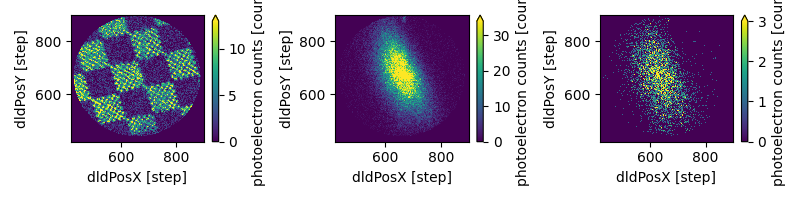

In [15]:
fig,ax = plt.subplots(1,3,figsize=(8,2), layout='tight')
res_chessy.plot(ax=ax[0], robust=True)
res_t05.plot(ax=ax[1], robust=True)
res_t10.plot(ax=ax[2], robust=True)

`TODO:` here we can add the evaluation of the spot size.

## Energy Calibration
We now load a bias series, where the sample bias was varied, effectively shifting the energy spectra. This allows us to calibrate the conversion between the digital values of the dld and the energy.

In [16]:
sp = SedProcessor(runs=[44797], config=config_override, system_config=config_file, collect_metadata=False)
sp.add_jitter()

System config loaded from: [/home/runner/work/sed/sed/docs/sed/config/flash_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]
Reading files: 0 new files of 5 total.
All files converted successfully!
Filling nan values...
loading complete in  0.03 s


We can use the `view_event_histogram()` function also to e.g. visualize the events per microbunch along the train, or hit multiplicity per microbunch:

In [17]:
sp.view_event_histogram(dfpid=0, axes=["pulseId", "electronId"], ranges=[[0, 600], [0,10]], bins=[100, 10])

### sector alignment
as usual first we jitter, but here we also align in time the 8 sectors of the dld. This is done by finding the time of the maximum of the signal in each sector, and then shifting the signal in each sector by the difference between the maximum time and the time of the maximum in each sector.

For better precision, the photon peak can be used to track the energy shift.

In [18]:
sp.align_dld_sectors()

### time-of-flight spectrum
to compare with what we see on the measurement computer, we might want to plot the time-of-flight spectrum. This is done here.

In [19]:
sp.append_tof_ns_axis()

Now, to determine proper binning ranges, let's have again a look at the event histograms:

In [20]:
sp.view_event_histogram(dfpid=0, axes=["sampleBias", "dldTime"], ranges=[[27, 33], [650,1050]], bins=[50, 100])

In [21]:
axes = ['sampleBias','dldTime']
bins = [5, 250]
ranges = [[28,33],  [650,800]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)

  0%|          | 0/2 [00:00<?, ?it/s]

We binned not only in `dldTime` but also in `sampleBias`. This allows us to separate the spectra obtained at different bias values. 

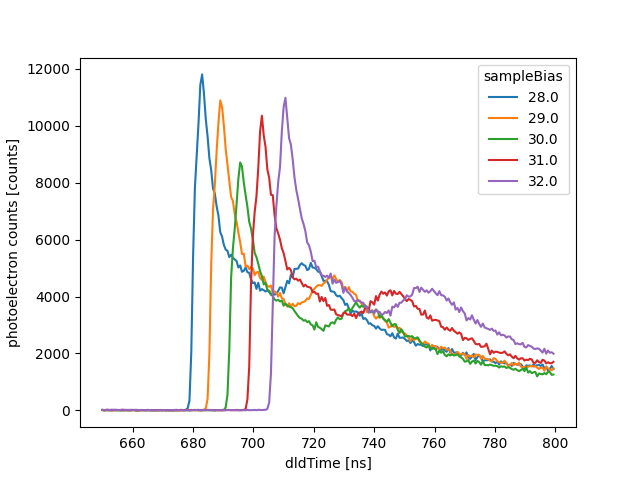

In [22]:
plt.figure()
res.plot.line(x='dldTime'); # the ; here is to suppress an annoying output

### find calibration parameters
We now will fit the tof-energy relation. This is done by finding the maxima of a peak in the tof spectrum, and then fitting the square root relation to obtain the calibration parameters. 

In [23]:
axes = ['sampleBias', 'dldTimeSteps']
bins = [5, 500]
ranges = [[28,33], [4000, 4800]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)

  0%|          | 0/2 [00:00<?, ?it/s]

In [24]:
sp.load_bias_series(binned_data=res)

interactive(children=(IntSlider(value=0, description='refid', max=10), IntRangeSlider(value=(4120, 4200), desc…

Button(description='apply', style=ButtonStyle())

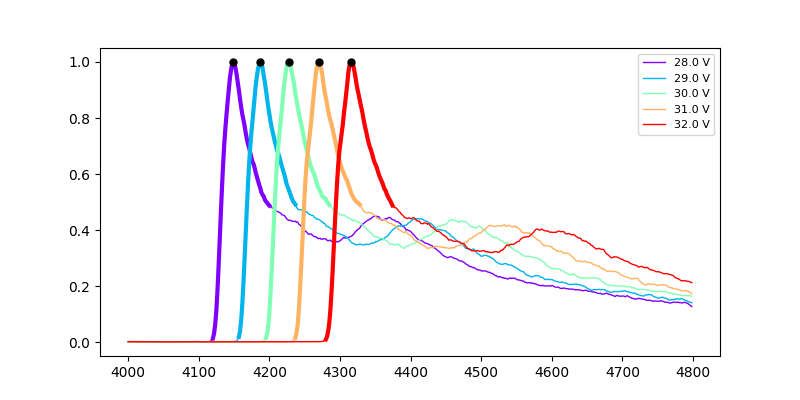

In [25]:
ranges=(4120, 4200)
ref_id=0
sp.find_bias_peaks(ranges=ranges, ref_id=ref_id, apply=True)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 22
    # data points      = 5
    # variables        = 2
    chi-square         = 1.9886e-04
    reduced chi-square = 6.6286e-05
    Akaike info crit   = -46.6618227
    Bayesian info crit = -47.4429469
[[Variables]]
    d:   1 (fixed)
    t0:  3.5727e-07 +/- 2.9058e-10 (0.08%) (init = 5e-07)
    E0: -54.7998131 +/- 0.04277721 (0.08%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, E0) = -0.9964
Quality of Calibration:


E/TOF relationship:


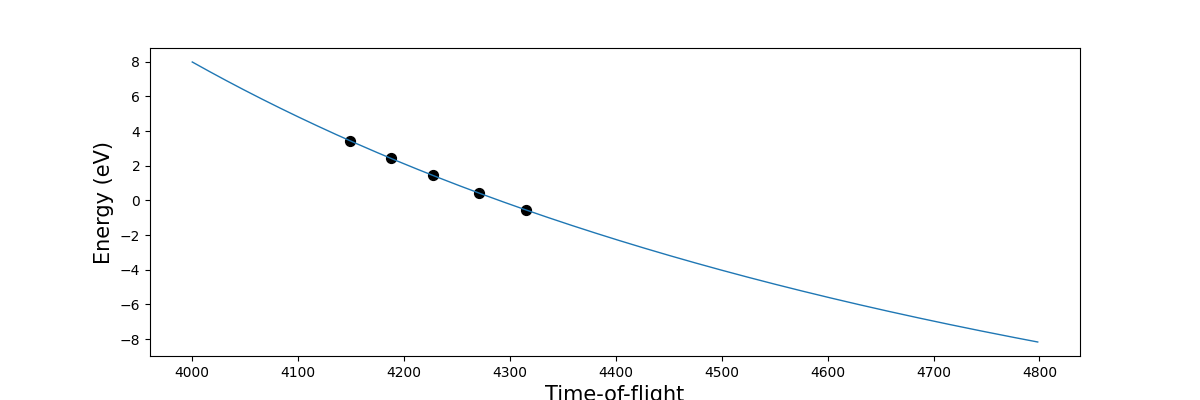

In [26]:
sp.calibrate_energy_axis(
    ref_id=4,
    ref_energy=-.55,
    method="lmfit",
    energy_scale='kinetic',
    d={'value':1.0,'min': .2, 'max':1.0, 'vary':False},
    t0={'value':5e-7, 'min': 1e-7, 'max': 1e-6, 'vary':True},
    E0={'value': 0., 'min': -100, 'max': 100, 'vary': True},
    verbose=True,
)

### generate the energy axis
Now that we have the calibration parameters, we can generate the energy axis for each spectrum

In [27]:
sp.append_energy_axis()

Lets have a look at the dataset, and the columns we added.

In [28]:
sp.dataframe[['dldTime','dldTimeSteps','energy','dldSectorID']].head()

dldTime  dldTimeSteps    energy  dldSectorID
0  696.402885   4230.647461  1.360472            1
1  696.562752   4231.618652  1.337184            0
2  697.718230   4238.638184  1.169841            1
3  697.817896   4239.243652  1.155487            4
4  745.162772   4526.863770 -4.463275            1

### Bin in energy
With the newly added column, we can now bin directly in energy

In [29]:
axes: List[str] = ['sampleBias', 'energy']
bins: List[int] = [5, 500]
ranges: List[List[int]] = [[28,33], [-10,10]]
res: xr.DataArray = sp.compute(bins=bins, axes=axes, ranges=ranges)

  0%|          | 0/2 [00:00<?, ?it/s]

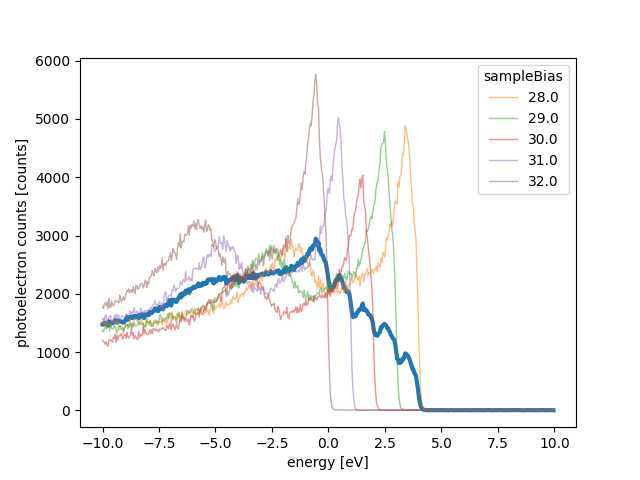

In [30]:
plt.figure() # if you are using interactive plots, you'll need to generate a new figure explicitly every time.
res.mean('sampleBias').plot.line(x='energy',linewidth=3)
res.plot.line(x='energy',linewidth=1,alpha=.5);

### correct offsets
The energy axis is now correct, but still the curves do not stack on each other as we are not compensating for the `sampleBias`. In the same way, we can compensate the photon energy (`monochromatorPhotonEnergy`) and the `tofVoltage` 

In [31]:
sp.add_energy_offset(
    constant=-32, # Sample bias used as reference for energy calibration
    columns=['sampleBias','monochromatorPhotonEnergy','tofVoltage'],
    weights=[1,-1,-1],
    preserve_mean=[False, True, True],
)

Now we bin again and see the result

In [32]:
axes = ['sampleBias', 'energy']
bins = [5, 500]
ranges = [[28,33], [-10,2]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)

  0%|          | 0/2 [00:00<?, ?it/s]

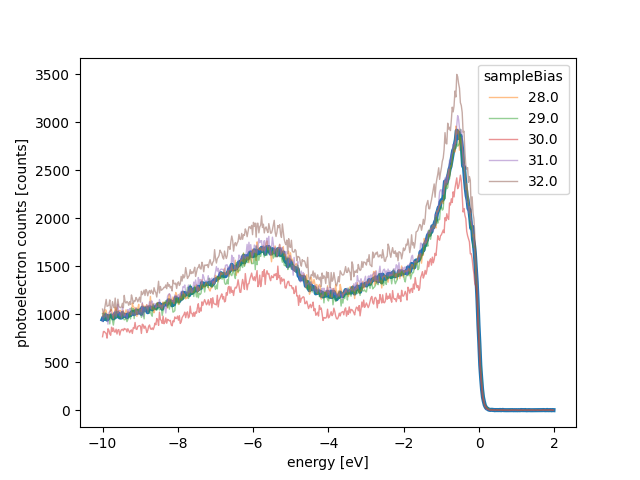

In [33]:
plt.figure()
ax = plt.subplot(111)
res.energy.attrs['unit'] = 'eV' # add units to the axes
res.mean('sampleBias').plot.line(x='energy',linewidth=3, ax=ax)
res.plot.line(x='energy',linewidth=1,alpha=.5,label='all',ax=ax);

### save the calibration parameters
The parameters we have found can be saved to a file, so that we can use them later. This means the calibration can be used for different runs.

In [34]:
sp.save_energy_calibration()
sp.save_energy_offset()

Saved energy calibration parameters to "sed_config.yaml".
Saved energy offset parameters to "sed_config.yaml".


A more general function, which saves parameters for all the calibrations performed. Use either the above or below function. They are equivalent (and overwrite each other)

In [35]:
sp.save_workflow_params()

Saved energy calibration parameters to "sed_config.yaml".
Saved energy offset parameters to "sed_config.yaml".


## Correct delay axis
To calibrate the pump-probe delay axis, we need to shift the delay stage values to center the pump-probe-time overlap `time zero`.
Also, we want to correct the SASE jitter, using information from the `bam` column.

Here we load multiple runs at once

In [36]:
sp = SedProcessor(
    runs=[44824,44825,44826,44827],
    config=config_override,
    system_config=config_file,
    collect_metadata=False,
)

Folder config loaded from: [/home/runner/work/sed/sed/docs/tutorial/sed_config.yaml]
System config loaded from: [/home/runner/work/sed/sed/docs/sed/config/flash_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]
Reading files: 0 new files of 62 total.
All files converted successfully!
Filling nan values...
loading complete in  0.13 s


### Run the workflow from the config file
as we have saved some calibration and correction parameters, we can now run the workflow from the config file. This is done by calling each of the correction functions, with no parameters. The functions will then load the parameters from the config file.

In [37]:
sp.add_jitter()
sp.align_dld_sectors()
sp.append_energy_axis()
sp.add_energy_offset()

### plot the delayStage values

In [38]:
axes = ['energy','delayStage']
bins = [100,150]
delay_start,delay_stop=1462.00,1464.85
ranges = [[-5,2], [delay_start,delay_stop]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)


  0%|          | 0/21 [00:00<?, ?it/s]

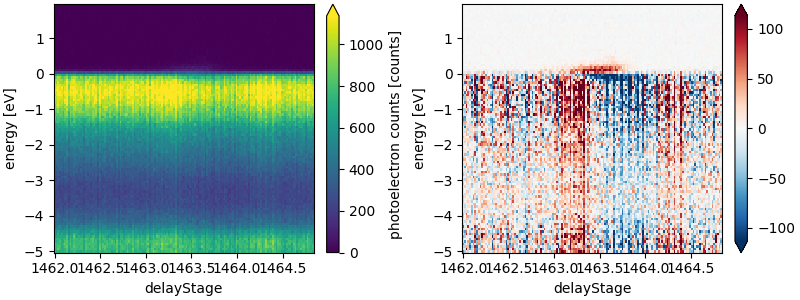

In [39]:
fig,ax = plt.subplots(1,2,figsize=(8,3), layout='constrained')
res.plot(robust=True, ax=ax[0])
bg = res.isel(delayStage=slice(0,10)).mean('delayStage')
(res-bg).plot(robust=True, ax=ax[1])

In [40]:
sp.add_delay_offset(
    constant=-1463.7, # this is time zero
    flip_delay_axis=True, # invert the direction of the delay axis
    columns=['bam'], # use the bam to offset the values
    weights=[-0.001], # bam is in fs, delay in ps
    preserve_mean=True # preserve the mean of the delay axis
)

In [41]:
sp.dataframe # This has generated too many layers, there is room for improvement!

Dask DataFrame Structure:
               trainId pulseId electronId timeStamp  dldPosX  dldPosY dldTimeSteps cryoTemperature dldTimeBinSize extractorCurrent extractorVoltage sampleBias sampleTemperature tofVoltage pulserSignAdc monochromatorPhotonEnergy   gmdBda      bam delayStage dldSectorID   energy
npartitions=62                                                                                                                                                                                                                                                                       
                uint32   int64      int64   float64  float64  float64      float32         float32        float32          float32          float32    float32           float32    float32       float32                   float32  float32  float32    float64        int8  float64
                   ...     ...        ...       ...      ...      ...          ...             ...            ...              ...              ...        ...               ...        ...           ...                       ...      ...      ...        ...         ...      ...
...                ...     ...        ...       ...      ...      ...          ...             ...            ...              ...              ...        ...               ...        ...           ...                       ...      ...      ...        ...         ...      ...
                   ...     ...        ...       ...      ...      ...          ...             ...            ...              ...              ...        ...               ...        ...           ...                       ...      ...      ...        ...         ...      ...
                   ...     ...        ...       ...      ...      ...          ...             ...            ...              ...              ...        ...               ...        ...           ...                       ...      ...      ...        ...         ...      ...
Dask Name: assign, 62 graph layers

### bin in the corrected delay axis

In [42]:
axes = ['energy','delayStage']
bins = [100,150]
delay_start,delay_stop=1462.00,1464.85
ranges = [[-3,2], [-1.15, 1.7]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges)

  0%|          | 0/21 [00:00<?, ?it/s]

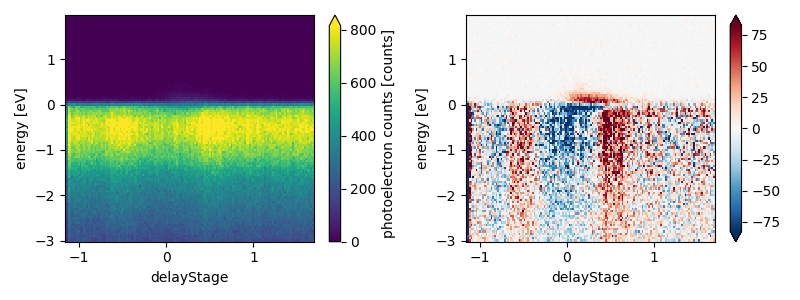

In [43]:
fig,ax = plt.subplots(1,2,figsize=(8,3))
res.plot(robust=True, ax=ax[0])
bg = res.sel(delayStage=slice(-1,-0.2)).mean('delayStage')
(res-bg).plot(robust=True, ax=ax[1])
fig.tight_layout()

You may note some intensity variation along the delay axis. This comes mainly from inhomogeneous speed of the delay stage, and thus inequivalent amounts of time spent on every delay point. This can be corrected for by normalizing the data to the acquisition time per delay point:

  0%|          | 0/21 [00:00<?, ?it/s]

Calculate normalization histogram for axis 'delayStage'...


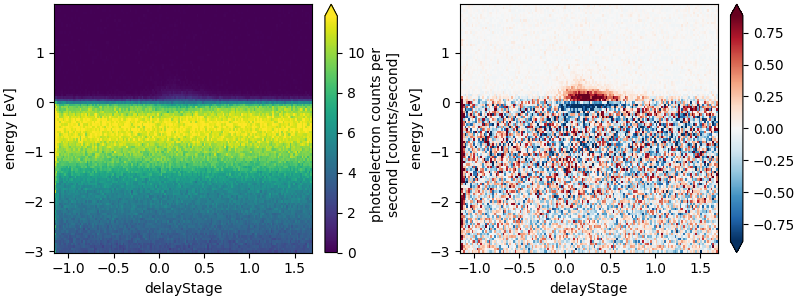

In [44]:
res = sp.compute(bins=bins, axes=axes, ranges=ranges, normalize_to_acquisition_time="delayStage")
fig,ax = plt.subplots(1,2,figsize=(8,3), layout='constrained')
res.plot(robust=True, ax=ax[0])
bg = res.sel(delayStage=slice(-1,-.2)).mean('delayStage')
(res-bg).plot(robust=True, ax=ax[1])

### save parameters
as before, we can save the parameters we just used in the config for the next run

In [45]:
sp.save_delay_offsets()

Saved delay offset parameters to "sed_config.yaml".


## Run workflow entirely from config.
Once all the calibrations are done, a new run can be loaded by simply calling all the calibration functions.

In [46]:
sp = SedProcessor(
    runs=[44824,44825,44826,44827],
    config=config_override,
    system_config=config_file,
    collect_metadata=False
)

Folder config loaded from: [/home/runner/work/sed/sed/docs/tutorial/sed_config.yaml]
System config loaded from: [/home/runner/work/sed/sed/docs/sed/config/flash_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]
Reading files: 0 new files of 62 total.
All files converted successfully!
Filling nan values...
loading complete in  0.08 s


In [47]:
sp.add_jitter()
sp.align_dld_sectors()
sp.append_tof_ns_axis()
sp.append_energy_axis()
sp.add_energy_offset()
sp.add_delay_offset()

### Compute the results

In [48]:
axes = ['energy','delayStage']
bins = [100,150]
delay_start,delay_stop=1462.00,1464.85
ranges = [[-5,2], [-1.15, 1.7]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges, normalize_to_acquisition_time="delayStage")

  0%|          | 0/21 [00:00<?, ?it/s]

Calculate normalization histogram for axis 'delayStage'...


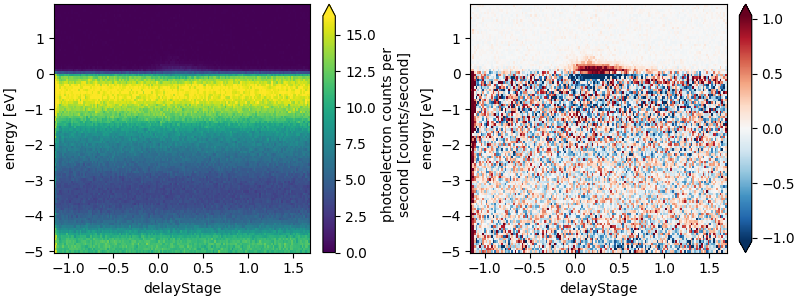

In [49]:
fig,ax = plt.subplots(1,2,figsize=(8,3), layout='constrained')
res.plot(robust=True, ax=ax[0])
bg = res.sel(delayStage=slice(-1,-.2)).mean('delayStage')
(res-bg).plot(robust=True, ax=ax[1])

## Save results
binned data can now be saved as h5 or tiff. igor binaries soon to come if requested!

In [50]:
sp.save('binned.h5')

saving data to binned.h5
Saved tof as string.
Saved reduction as string.
Saved reduction as string.
Saved reduction as string.
Saved reduction as string.
Saving complete!


In [51]:
sp.save('binned.tiff')

Successfully saved binned.tiff
 Axes order: ['delayStage', 'energy', 'C', 'Y', 'X', 'S']
